In [1]:
import datetime
import os
import re
import numpy as np
from seabird import fCNV
import seapy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import scipy.io as sio
import cmaps
from matplotlib.colors import LinearSegmentedColormap
from cotede import datasets, qctests

NumExpr defaulting to 8 threads.


In [2]:
class insitu_workspace():
    def __init__(self,MY_ROOT,worksapce_name, workspace_detail=None):
        self.my_root = MY_ROOT
        self.workspace_name = worksapce_name
        self.workspace_detail = workspace_detail
        self.workspace_subdir = os.path.join(self.my_root, self.workspace_name)
        print('Workspace: ' + self.workspace_subdir)
        self.ctd_files = seapy.list_files(os.path.join(self.workspace_subdir+'/CTD/*acfld.cnv'))
        self.ctd_stationinfo = os.path.join(self.workspace_subdir,self.workspace_name+'-station.txt')
        self.isempty = True
        
        
    class Data():
        def __init__(self):
            self.filetype = 'ctd data structure'
            




    def pull_downcast(self,ctd_file,VAR):
        def lanczos_filter(data,Cf,Nf,M):
            coef = sp.signal.firwin(M+1, Cf/Nf,width = 2/len(data),window='lanczos', pass_zero='lowpass')
            return sp.signal.filtfilt(coef,1.0,data)

        dt = 0.04 #sec
        fs = 1/(dt)
        Nf = fs/2
        Cf = fs/1500
        M = 100
        # print(ctd_file)
        profile = fCNV(ctd_file)
        time    = profile['timeS'][:]
        if VAR == 'PSAL2':
            var = profile.data[-6][:]
        else:
            var     = profile[VAR][:]
        pres    = profile['PRES'][:]
        depth   = profile['DEPTH'][:]
        # smooth the noise further
        # print(np.nanmax(time))
        # smooth data based on the data length 
        if np.nanmax(time)>3000:
            pres_conv = np.convolve(pres,np.ones(24*6*5)/24/6/5,mode='full')[72*5:-72*5+1]
            pres_conv = seapy.filt.bandpass(pres_conv,dt,low_cutoff=dt*2000,order=4)
        elif (self.workspace_name == 'IOCAS2013SPRING') and (('3400-05' in ctd_file) or ('3300-03' in ctd_file)):
            # specified data file, not follow the general rules.
            pres_conv = np.convolve(pres,np.ones(24*3)/24/3,mode='full')[36:-35]
            pres_conv = seapy.filt.bandpass(pres_conv,dt,low_cutoff=dt*50,order=12)
        elif (np.nanmax(time) > 370)  or ((self.workspace_name == 'NSFC2012SPRING-ES') and ('ZB-13' in ctd_file)):
             # specified data file, not follow the general rules.
            pres_conv = np.convolve(pres,np.ones(24*6)/24/6,mode='full')[72:-71]
            pres_conv = seapy.filt.bandpass(pres_conv,dt,low_cutoff=dt*200,order=8)
        else:
            pres_conv = np.convolve(pres,np.ones(24*3)/24/3,mode='full')[36:-35]
            pres_conv = seapy.filt.bandpass(pres_conv,dt,low_cutoff=dt*50,order=12)
        
        diff_pres = np.diff(pres_conv)
    #    diff_pres_conv = np.convolve(diff_pres,np.ones(24*6)/24/6,mode='full')[72:-71]
        diff_pres_conv = diff_pres.copy()
        count_down = 0
        count_up = 0
        for i in range(1,len(diff_pres_conv)):
            # print(diff_pres[i])
            # print(diff_pres[i]*diff_pres[i-1])
            if (diff_pres_conv[i]*diff_pres_conv[i-1]) < 0 :
                if diff_pres_conv[i-1]>0:
                    if  not count_down:
                        start_down = i
                    else:
                        start_down = np.r_[start_down, i]
                    count_down+=1
                else:
                    if not count_up :
                        start_up = i
                    else:
                        start_up = np.r_[start_up, i]
                    count_up+=1


    #        print(start_up)
    #        print(start_down)


        # print(pres[start_down[1]])
        larger = 1
        smaller = -1
        equal = 0
    #    print(len(start_down))
    #    print(len(start_up))
        if len(start_up) > len(start_down):
            end_indx = len(start_down)
            status = larger
        elif len(start_up) < len(start_down):
            end_indx = len(start_up)
            status = smaller
        else:
            status = equal


        if start_down[0] < start_up[0]:
            if status == equal:
                mono_duration = start_up[:-1] - start_down[1:]
            elif status == larger:
                mono_duration = start_up[:end_indx-1] - start_down[1:]
            elif status == smaller:
                mono_duration = start_up[:] - start_down[1:]
    #        print(mono_duration)
            downcast_index = np.argmax(np.abs(mono_duration))
    #        print(downcast_index)
            if ((pres[start_down[downcast_index+1]] -
                      pres[start_up[downcast_index]]) < 5):
                mono_duration[downcast_index] = 0
                downcast_index = np.argmax(np.abs(mono_duration))
            mono_duration[downcast_index] = 0

            downcast2_index = np.argmax(np.abs(mono_duration))

            if (downcast2_index > downcast_index)\
                and ((pres[start_down[downcast2_index+1]] - 
                      pres[start_up[downcast2_index]]) > 5)\
                and (pres[start_up[downcast2_index]]>pres[start_down[downcast_index+1]]):
                time_downcast = np.r_[
                                      time[start_up[downcast_index]:start_down[downcast_index+1]],
                                      time[start_up[downcast2_index]:start_down[downcast2_index+1]]

                                      ]
                pres_downcast = np.r_[
                                      pres[start_up[downcast_index]:start_down[downcast_index+1]],
                                      pres[start_up[downcast2_index]:start_down[downcast2_index+1]]
                                      ]
                depth_downcast = np.r_[
                                      depth[start_up[downcast_index]:start_down[downcast_index+1]],
                                      depth[start_up[downcast2_index]:start_down[downcast2_index+1]]
                                      ]
                var_downcast = np.r_[
                                       var[start_up[downcast_index]:start_down[downcast_index+1]],
                                       var[start_up[downcast2_index]:start_down[downcast2_index+1]]
                                    ]
            elif (downcast2_index < downcast_index)\
                   and((pres[start_down[downcast2_index+1]] - 
                  pres[start_up[downcast2_index]]) < np.max(pres) *0.7)\
                and ((((pres[start_down[downcast2_index+1]] - 
                  pres[start_up[downcast2_index]]) > np.max(pres) *0.4) \
                and ((time[start_up[downcast_index]] -
                  time[start_down[downcast2_index+1]]) <np.max(time)*0.1))\
                or (((pres[start_down[downcast2_index+1]] - 
                  pres[start_up[downcast2_index]]) > np.max(pres) *0.2) \
                and ((time[start_up[downcast_index]] -
                  time[start_down[downcast2_index+1]]) <np.max(time)*0.05))\
                or((time[start_up[downcast_index]] -
                  time[start_down[downcast2_index+1]]) <np.max(time)*0.005)): # judge that the interval between two downcast is small enough
                time_downcast = np.r_[
                                      time[start_up[downcast2_index]:start_down[downcast2_index+1]],
                                      time[start_up[downcast_index]:start_down[downcast_index+1]]

                                      ]
                pres_downcast = np.r_[
                                      pres[start_up[downcast2_index]:start_down[downcast2_index+1]],
                                      pres[start_up[downcast_index]:start_down[downcast_index+1]]
                                      ]
                depth_downcast = np.r_[
                                      depth[start_up[downcast2_index]:start_down[downcast2_index+1]],
                                      depth[start_up[downcast_index]:start_down[downcast_index+1]]
                                      ]
                var_downcast = np.r_[
                                       var[start_up[downcast2_index]:start_down[downcast2_index+1]],
                                       var[start_up[downcast_index]:start_down[downcast_index+1]]
                                    ]
            else:

                time_downcast = time[start_up[downcast_index]:start_down[downcast_index+1]]
                pres_downcast = pres[start_up[downcast_index]:start_down[downcast_index+1]]
                depth_downcast = depth[start_up[downcast_index]:start_down[downcast_index+1]]
                var_downcast = var[start_up[downcast_index]:start_down[downcast_index+1]]
                
            



        else:
            if status == equal:
                mono_duration = start_up - start_down
            elif status == larger:
                mono_duration = start_up[:end_indx] - start_down
            elif status == smaller:
                mono_duration = start_up[:] - start_down[:end_indx]

    #        print(mono_duration)
            downcast_index = np.argmax(np.abs(mono_duration))
    #        print(downcast_index)
            if ((pres[start_down[downcast_index]] -
                      pres[start_up[downcast_index]]) < 5):
                mono_duration[downcast_index] = 0
                downcast_index = np.argmax(np.abs(mono_duration))
            mono_duration[downcast_index] = 0
            downcast2_index = np.argmax(np.abs(mono_duration))
            if (downcast2_index > downcast_index)\
                and ((pres[start_down[downcast2_index]] - 
                      pres[start_up[downcast2_index]]) > 5)\
                and (pres[start_up[downcast2_index]]>pres[start_down[downcast_index]]):
                time_downcast = np.r_[
                                      time[start_up[downcast_index]:start_down[downcast_index]],
                                      time[start_up[downcast2_index]:start_down[downcast2_index]]

                                      ]
                pres_downcast = np.r_[
                                      pres[start_up[downcast_index]:start_down[downcast_index]],
                                      pres[start_up[downcast2_index]:start_down[downcast2_index]]
                                      ]
                depth_downcast = np.r_[
                                      depth[start_up[downcast_index]:start_down[downcast_index]],
                                      depth[start_up[downcast2_index]:start_down[downcast2_index]]
                                      ]
                
                var_downcast = np.r_[
                                       var[start_up[downcast_index]:start_down[downcast_index]],
                                       var[start_up[downcast2_index]:start_down[downcast2_index]]
                                    ]
            elif (downcast2_index < downcast_index)\
                   and ((pres[start_down[downcast2_index]] - 
                  pres[start_up[downcast2_index]]) < np.max(pres)*0.7)\
                 and ((((pres[start_down[downcast2_index]] - 
                  pres[start_up[downcast2_index]]) > np.max(pres)*0.4) \
                and ((time[start_up[downcast_index]] -
                  time[start_down[downcast2_index]]) <np.max(time)*0.1))\
              or (((pres[start_down[downcast2_index]] - 
                  pres[start_up[downcast2_index]]) > np.max(pres)*0.2) \
                and ((time[start_up[downcast_index]] -
                  time[start_down[downcast2_index]]) <np.max(time)*0.05))\
                or((time[start_up[downcast_index]] -
                  time[start_down[downcast2_index]]) <np.max(time)*0.005)): # judge that the interval between two downcast is small enough
                time_downcast = np.r_[
                                      time[start_up[downcast2_index]:start_down[downcast2_index]],
                                      time[start_up[downcast_index]:start_down[downcast_index]]

                                      ]
                pres_downcast = np.r_[
                                      pres[start_up[downcast2_index]:start_down[downcast2_index]],
                                      pres[start_up[downcast_index]:start_down[downcast_index]]
                                      ]
                depth_downcast = np.r_[
                                      depth[start_up[downcast2_index]:start_down[downcast2_index]],
                                      depth[start_up[downcast_index]:start_down[downcast_index]]
                                      ]
                var_downcast = np.r_[
                                       var[start_up[downcast2_index]:start_down[downcast2_index]],
                                       var[start_up[downcast_index]:start_down[downcast_index]]
                                    ]
            else:

                time_downcast = time[start_up[downcast_index]:start_down[downcast_index]]
                pres_downcast = pres[start_up[downcast_index]:start_down[downcast_index]]
                depth_downcast = depth[start_up[downcast_index]:start_down[downcast_index]]
                var_downcast = var[start_up[downcast_index]:start_down[downcast_index]]
            
            
        return time_downcast.data, pres_downcast.data, depth_downcast.data, var_downcast.data

    def pull_ctdinfos(self):
        self.ctd_infos = {}
        ctdid = open(self.ctd_stationinfo)
        info = ctdid.readline().split()
        cid = 0
        while info:
            self.ctd_infos[info[1]]={}
            self.ctd_infos[info[1]]['TIME'] = (datetime.datetime.strptime(info[2],'%Y%m%d%H%M') - 
                                              datetime.datetime(1970,1,1)).total_seconds()/3600/24
            self.ctd_infos[info[1]]['LONGITUDE']=info[3]
            self.ctd_infos[info[1]]['LATITUDE']=info[4]
            self.ctd_infos[info[1]]['DEPTH'] = info[5]
            self.ctd_infos[info[1]]['CTDID'] = cid
            cid +=1
            info = ctdid.readline().split()
        ctdid.close()
        
    def pull_alldata(self,VARS, refine_withqc_id=None):
        if self.isempty:
            self.data = {}
            self.isempty = False
        for iv, var in enumerate(VARS):
            print(var)
            self.data[var] = self.Data()
            if len(refine_withqc_id[var]) > 0:
                print('qc specified: ')
                print(refine_withqc_id[var])
                needqc=True
            else:
                needqc=False
            for ic, ctd_file in enumerate(self.ctd_files):
                # print(ctd_file)
                
                ctdid = re.findall(r"%s/CTD/(.*)acfld.cnv"%(self.workspace_subdir),ctd_file)[0]
                # print(ctdid)
                # print(needqc)
                if needqc:
                    if ctdid in refine_withqc_id[var]:
                        # print('qc is activated')
                        idneedqc=True
                    else:
                        idneedqc=False
                else:
                    idneedqc=False
                
                if ic == 0:
                    _, self.data[var].pres, self.data[var].depth, self.data[var].value = self.pull_downcast(ctd_file,var)
                    #remove negative depth
                    valid_depth = np.where(self.data[var].depth>0)
                    self.data[var].pres = self.data[var].pres[valid_depth]
                    self.data[var].depth = self.data[var].depth[valid_depth]
                    self.data[var].value = self.data[var].value[valid_depth]
                    self.data[var].station = np.tile(ctdid,[len(self.data[var].value),]).ravel()
                    self.data[var].time = np.tile(float(self.ctd_infos[ctdid]['TIME']),[len(self.data[var].value),]).ravel()
                    self.data[var].lon = np.tile(float(self.ctd_infos[ctdid]['LONGITUDE']),[len(self.data[var].value),]).ravel()
                    self.data[var].lat = np.tile(float(self.ctd_infos[ctdid]['LATITUDE']),[len(self.data[var].value),]).ravel()
                    
                    # interpolating
                    
                    # print('interp is activate')

                    data_len = int(np.floor(0.95*len(self.data[var].value)))
                    pres_cut = self.data[var].pres[:data_len] 
                    # splitted based on pressure
                    # cut the tail of data
                    pres_levels = np.arange(np.ceil(np.min(pres_cut)),
                                               np.floor(np.max(pres_cut)),
                                               )

                    self.data[var].station_i = np.tile(ctdid,[len(pres_levels),]).ravel()
                    self.data[var].time_i = np.tile(float(self.ctd_infos[ctdid]['TIME']),[len(pres_levels),]).ravel()
                    self.data[var].lon_i = np.tile(float(self.ctd_infos[ctdid]['LONGITUDE']),[len(pres_levels),]).ravel()
                    self.data[var].lat_i = np.tile(float(self.ctd_infos[ctdid]['LATITUDE']),[len(pres_levels),]).ravel()
                    self.data[var].depth_i = seapy.seawater.depth(pres_levels, lat=float(self.ctd_infos[ctdid]['LATITUDE']))
                    self.data[var].pres_i = pres_levels.copy()
                    self.data[var].value_i = np.interp(pres_levels,pres_cut,self.data[var].value[:data_len])
                    
                    # refining
                    grad_value_r = np.diff(self.data[var].value_i)
                    grad_value_r = np.abs(np.r_[grad_value_r[0],grad_value_r])
                    grad_value_l = np.diff(self.data[var].value_i)
                    grad_value_l = np.abs(np.r_[grad_value_l,grad_value_l[-1]])
                    grad_value = (grad_value_r+grad_value_l)/2
                    if var =='PSAL2':
                        grad_value = 1/(1+np.exp(-grad_value**2))
                    elif var =='TEMP':
                        grad_value = 1/(1+np.exp(-grad_value))
                    
                    refine_levels = np.linspace(np.min(pres_levels),np.max(pres_levels),1000)
                        
    
                    if idneedqc:
                        
                        print("quality control is activate: %s"%(ctdid))
                        value_qc = self.data[var].value_i[grad_value<np.mean(grad_value)]
                        pres_qc = self.data[var].pres_i[grad_value<np.mean(grad_value)]
                            
                    else:
                        value_qc = self.data[var].value_i.copy()
                        pres_qc = self.data[var].pres_i.copy()
                    

                    self.data[var].value_r = np.interp(refine_levels,pres_qc,value_qc)
                    self.data[var].pres_r = refine_levels.copy()
                    self.data[var].depth_r = seapy.seawater.depth(refine_levels, lat=float(self.ctd_infos[ctdid]['LATITUDE']))
                    self.data[var].time_r =  np.tile(float(self.ctd_infos[ctdid]['TIME']),[len(refine_levels),]).ravel()
                    self.data[var].lon_r =  np.tile(float(self.ctd_infos[ctdid]['LONGITUDE']),[len(refine_levels),]).ravel()
                    self.data[var].lat_r = np.tile(float(self.ctd_infos[ctdid]['LATITUDE']),[len(refine_levels),]).ravel()
                    self.data[var].station_r = np.tile(ctdid,[len(refine_levels),]).ravel()




                        
                else:
                    
                    _, thispres, thisdepth, thisvalue = self.pull_downcast(ctd_file,var)
                    #remove negative depth
                    valid_depth = np.where(thisdepth>0)
                    thispres = thispres[valid_depth]
                    thisvalue = thisvalue[valid_depth]
                    thisdepth = thisdepth[valid_depth]
                    thisstation = np.tile(ctdid,[len(thisvalue),]).ravel()
                    thistime = np.tile(float(self.ctd_infos[ctdid]['TIME']),[len(thisvalue),]).ravel()
                    thislon = np.tile(float(self.ctd_infos[ctdid]['LONGITUDE']),[len(thisvalue),]).ravel()
                    thislat = np.tile(float(self.ctd_infos[ctdid]['LATITUDE']),[len(thisvalue),]).ravel()
                    self.data[var].station  = np.r_[self.data[var].station ,thisstation]
                    self.data[var].time  = np.r_[self.data[var].time ,thistime]
                    self.data[var].pres  = np.r_[self.data[var].pres ,thispres]
                    self.data[var].depth = np.r_[self.data[var].depth,thisdepth]
                    self.data[var].value = np.r_[self.data[var].value,thisvalue]
                    self.data[var].lon   = np.r_[self.data[var].lon,thislon]
                    self.data[var].lat   = np.r_[self.data[var].lat,thislat]
                    
                    # interpolating
                    # print('interp is activate')

                    data_len = int(np.floor(0.95*len(thisvalue)))
                    pres_cut = thispres[:data_len] 
                    # splitted based on pressure
                    # cut the tail of data
                    pres_levels = np.arange(np.ceil(np.min(pres_cut)),
                                               np.floor(np.max(pres_cut)),
                                               )

                    thisstation_i = np.tile(ctdid,[len(pres_levels),]).ravel()
                    thistime_i = np.tile(float(self.ctd_infos[ctdid]['TIME']),[len(pres_levels),]).ravel()
                    thislon_i = np.tile(float(self.ctd_infos[ctdid]['LONGITUDE']),[len(pres_levels),]).ravel()
                    thislat_i = np.tile(float(self.ctd_infos[ctdid]['LATITUDE']),[len(pres_levels),]).ravel()
                    thisdepth_i = seapy.seawater.depth(pres_levels, lat=float(self.ctd_infos[ctdid]['LATITUDE']))
                    thispres_i = pres_levels.copy()
                    thisvalue_i = np.interp(pres_levels,pres_cut,thisvalue[:data_len])
                    self.data[var].station_i = np.r_[self.data[var].station_i, thisstation_i]
                    self.data[var].time_i = np.r_[self.data[var].time_i, thistime_i]
                    self.data[var].lon_i = np.r_[self.data[var].lon_i, thislon_i]
                    self.data[var].lat_i = np.r_[self.data[var].lat_i, thislat_i]
                    self.data[var].depth_i = np.r_[self.data[var].depth_i, thisdepth_i]
                    self.data[var].pres_i = np.r_[self.data[var].pres_i, thispres_i]
                    self.data[var].value_i = np.r_[self.data[var].value_i,thisvalue_i]
                        
                    
                    # refining  
                    
                    grad_value_r = np.diff(thisvalue_i)
                    grad_value_r = np.abs(np.r_[grad_value_r[0],grad_value_r])
                    grad_value_l = np.diff(thisvalue_i)
                    grad_value_l = np.abs(np.r_[grad_value_l,grad_value_l[-1]])
                    grad_value = (grad_value_r+grad_value_l)/2
                    if var =='PSAL2':
                        grad_value = 1/(1+np.exp(-grad_value**2))
                    elif var =='TEMP':
                        grad_value = 1/(1+np.exp(-grad_value))
                    
                    
                    refine_levels = np.linspace(np.min(pres_levels),np.max(pres_levels),1000)


                            
                          
                    if idneedqc:
                        print("quality control is activate: %s"%(ctdid))
                        value_qc = thisvalue_i[grad_value<np.mean(grad_value)]
                        pres_qc = thispres_i[grad_value<np.mean(grad_value)]
                    else:
                        value_qc = thisvalue_i.copy()
                        pres_qc = thispres_i.copy()

                    thisvalue_r = np.interp(refine_levels,pres_qc,value_qc)
                    thispres_r = refine_levels.copy()
                    thisdepth_r = seapy.seawater.depth(refine_levels, lat=float(self.ctd_infos[ctdid]['LATITUDE']))
                    thistime_r =  np.tile(float(self.ctd_infos[ctdid]['TIME']),[len(refine_levels),]).ravel()
                    thislon_r =  np.tile(float(self.ctd_infos[ctdid]['LONGITUDE']),[len(refine_levels),]).ravel()
                    thislat_r = np.tile(float(self.ctd_infos[ctdid]['LATITUDE']),[len(refine_levels),]).ravel()
                    thisstation_r = np.tile(ctdid,[len(refine_levels),]).ravel()
                    self.data[var].station_r = np.r_[self.data[var].station_r, thisstation_r]
                    self.data[var].time_r = np.r_[self.data[var].time_r, thistime_r]
                    self.data[var].lon_r = np.r_[self.data[var].lon_r, thislon_r]
                    self.data[var].lat_r = np.r_[self.data[var].lat_r, thislat_r]
                    self.data[var].depth_r = np.r_[self.data[var].depth_r, thisdepth_r]
                    self.data[var].pres_r = np.r_[self.data[var].pres_r, thispres_r]
                    self.data[var].value_r = np.r_[self.data[var].value_r,thisvalue_r]
                    
    
        
            
                    
                    
                   
                
                
            
        

In [1318]:
# dataset = 'NSFC2012SPRING-YS'
# dataset = 'NSFC2012SPRING-ES'
# dataset = 'IOCAS2012SPRING'
# dataset = 'NSFC2012AUTUMN-ES'
# dataset = 'IOCAS2012AUTUMN'
# dataset = 'NSFC2013SPRING-CJ'
dataset = 'IOCAS2013SPRING'
test =insitu_workspace('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS',dataset,dataset)

Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2013SPRING


In [1319]:
test.pull_ctdinfos()

In [903]:
test.ctd_files

['/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012AUTUMN/CTD/3300-01acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012AUTUMN/CTD/3300-02acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012AUTUMN/CTD/3300-03acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012AUTUMN/CTD/3300-04acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012AUTUMN/CTD/3300-05acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012AUTUMN/CTD/3300-06acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012AUTUMN/CTD/3400-01acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012AUTUMN/CTD/3400-02acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012AUTUMN/CTD/3400-03acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/IOCAS2012AUTUMN/CTD/3400-04acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSIT

In [1320]:
# must pull_ctdinfos before pull_alldata
# -------------NSFC2012SPRING-YS
# test.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':['H03','H16','H25','H34'],'TEMP':[]})
# -------------NSFC2012SPRING-ES
# test.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':[],'TEMP':[]})
# -------------IOCAS2012SPRING
# test.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':['3800-01','3800-02','B-03','DH6-2'],'TEMP':['DH6-2',]})
# -------------NSFC2012AUTUMN-ES
# test.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':[],'TEMP':[]})
# -------------IOCAS2012AUTUMN
# test.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':['3500-09',],'TEMP':['3500-09','DH4-1']})
# -------------NSFC2013SPRING-CJ
# test.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':['A01-03','A01-09','A02-04','A02-08','A03-06','A03-09','A04-07','A06-05','A13-01'],'TEMP':['A04-07',]})
# -------------IOCAS2013SPRING
test.pull_alldata(VARS=['PSAL2','TEMP'],refine_withqc_id={'PSAL2':['3600-05','3800-04',],'TEMP':[]})

PSAL2
qc specified: 
['3600-05', '3800-04', 'B-04']
quality control is activate: 3600-05
quality control is activate: 3800-04
quality control is activate: B-04
TEMP


In [1322]:
# merge sst and in-situ togethor
grdfile = '/Volumes/TO_1/outputs_SCORRECTION/ocean_ecs_fwd_15461_outer1.nc'
dt = 1/24
# reftime = datetime.datetime(1970,1,1)

grid = seapy.model.asgrid(grdfile)
data = [seapy.roms.obs.raw_data("TEMP", "CTD", test.data['TEMP'].value_r,None,0.1),
       seapy.roms.obs.raw_data("SALT", "CTD", test.data['PSAL2'].value_r,None,0.01),]
        
insitu_obs = seapy.roms.obs.gridder(grid,test.data['TEMP'].time_r,
                                    test.data['TEMP'].lon_r,test.data['TEMP'].lat_r,
                                    -test.data['TEMP'].depth_r, data,dt,title="cruise CTD observation")

Output()

In [ ]:
np.unique(test.data['TEMP'].station_r[station_position])

In [ ]:
plt.plot(test.data['TEMP'].lon[station_position])

In [ ]:
stationsets[1]

In [ ]:
test.data.keys()

In [1428]:
#temp profile
%matplotlib
import matplotlib.tri as tri
VAR='PSAL2'
# VAR='TEMP'
# -------------NSFC2012SPRING-YS
# stations = ['E01','E02','E03','E04','E05']
# stations = ['H01','H02','H03','H04','H05','H06','H07','H08','H09']
# stations = ['H10','H11','H12','H13','H14','H15','H16','H17','H18','H19']
# stations = ['H25','H26','H27','H28','H29',] # 'H30'
# stations = ['H31','H32','H33','H34','H35','H36']
# stations = ['H37','H38','H39','H40','H41','H42']
# stations = ['HF1','HF2','HF3','H44','H43',]
# stations = []
# -------------NSFC2012SPRING-ES
# stations = ['DH3-01','DH3-02','DH3-03','DH3-04','DH3-05','DH3-06','DH3-07','DH3-08',]
# stations = ['RB-10','RB-16']
# stations = ['DH4-01','DH4-02','DH4-03','DH4-04','DH4-05','DH4-06',]
# stations = ['ZA-05','ZA-03','ZA-01']
# stations = ['GC-05','ZB-07','ZB-09','ZB-11','DH5-01','GC-06','ZB-12','DH5-02','DH5-03','DH5-04','DH5-05','DH5-06']
# stations = ['DH6-05','DH6-04','DH6-03','DH6-02','ZC-17','DH6-01','ZC-15','ZC-13']
# stations = ['ZD-19','ZD-21','DH7-01','ZD-24','DH7-02','DH7-03','DH7-04','DH7-05']
# stations = ['DH8-05','DH8-04','DH8-03','DH8-02','ZE-27','DH8-01','ZE-25']
# stations = ['GC-07', 'DH9-01','DH9-02','DH9-03','DH9-04','DH9-05','DH9-06']
# -------------IOCAS2012SPRING
# stations = ['DH9-1','DH9-2','DH9-3','DH9-4','DH9-5','DH9-6']
# stations = ['DH8-5','DH8-4','DH8-3','DH8-2','DH8-1']
# stations = ['DH7-1','DH7-2','DH7-3','DH7-4','DH7-5']
# stations = ['DH6-5','DH6-4','DH6-3','DH6-2','DH6-1']
# stations = ['DH5-1','DH5-2','DH5-3','DH5-4','DH5-5','DH5-6']
# stations = ['DH4-6','DH4-5','DH4-4','DH4-3','DH4-2','DH4-1']
# stations = ['DH3-1','DH3-2','DH3-3','DH3-4','DH3-5','DH3-6','DH3-7','DH3-8']
# stations = ['DH2-7','DH2-6','DH2-5','DH2-4','DH2-3','DH2-2','DH2-1']
# stations = ['DH1-7','DH1-8']
# stations = ['CJ-1','CJ-2','CJ-3','CJ-4','CJ-5','CJ-6']
# stations=['3300-06','3300-05','3300-04','3300-03','3300-02','3300-01']
# stations = ['3400-01','3400-02','3400-03','3400-04','3400-05','3400-06','3400-07','3400-08']
# stations = ['3500-10','3500-09','3500-08','3500-07','3500-06','3500-05','3500-04','3500-03','3500-02','3500-01']
# stations = ['3600-01','3600-02','3600-03','3600-04','3600-05','3600-06','3600-07','3600-08']
# stations =['B-08','B-07','B-06','B-05','B-04','B-03','B-02','B-01']
# stations = ['3875-01','3875-02','3875-03','3875-04','3875-05']
# stations = ['3800-04','3800-03','3800-02','3800-01']
# stations = ['3700-01','3700-02','3700-03']
# -------------NSFC2012AUTUMN-ES
# stations = ['DH3-1','DH3-2','DH3-3','DH3-4','DH3-5','DH3-6','DH3-7','DH3-8']
# stations = ['DH4-8','DH4-7','DH4-6','DH4-5','DH4-4','DH4-3','DH4-2','DH4-1']
# stations = ['DH5-1','DH5-2','DH5-3','DH5-4','DH5-5','DH5-6','DH5-7','DH5-8']
# stations = ['DH8-9','DH8-8','DH8-6','DH8-5','DH8-4','DH8-2','DH8-1']
# -------------IOCAS2012AUTUMN
# stations = ['DH9-1','DH9-2','DH9-3','DH9-4','DH9-5','DH9-6','DH9-7']
# stations = ['DH8-6','DH8-5','DH8-4','DH8-3','DH8-2','DH8-1']
# stations = ['DH7-1','DH7-2','DH7-3','DH7-4','DH7-5','DH7-6','DH7-7','DH7-8']
# stations = ['DH6-7','DH6-6','DH6-5','DH6-4','DH6-3','DH6-2','DH6-1']
# stations = ['DH5-1','DH5-2','DH5-3','DH5-4','DH5-5','DH5-6','DH5-7','DH5-8','DH5-9']
# stations = ['DH4-8','DH4-7','DH4-6','DH4-5','DH4-4','DH4-3','DH4-2','DH4-1']
# stations = ['DH3-1','DH3-2','DH3-3','DH3-4','DH3-5','DH3-6','DH3-7','DH3-8']
# stations = ['DH2-7','DH2-6','DH2-5','DH2-4','DH2-3','DH2-2','DH2-1']
# stations = ['CJ-01','CJ-02','CJ-03','CJ-04','CJ-05','CJ-06']
# stations = ['DH1-8','DH1-7']
# stations = ['3300-06','3300-05','3300-04','3300-03','3300-02','3300-01']
# stations = ['3400-01','3400-02','3400-03','3400-04','3400-05','3400-06','3400-07','3400-08']
# stations = ['3500-01','3500-02','3500-03','3500-04','3500-05','3500-06','3500-07','3500-08','3500-09','3500-10']
# stations = ['3600-08','3600-07','3600-06','3600-05','3600-04','3600-03','3600-02','3600-01']
# stations = ['3700-01','3700-02','3700-03']
# stations = ['3800-04','3800-03','3800-02','3800-01']
# stations = ['B-08','B-07','B-06','B-05','B-04','B-03','B-02','B-01']
# stations = ['3875-01','3875-02','3875-03','3875-04','3875-05']
# -------------NSFC2013SPRING-CJ
# stations = ['A01-01','A01-02','A01-03','A01-04','A01-05','A01-06','A01-07','A01-08','A01-09']
# stations = ['A02-09','A02-08','A02-07','A02-06','A02-05','A02-04']
# stations = ['A03-04','A03-05','A03-06','A03-07','A03-08','A03-09','A03-10','A03-11']
# stations = ['A04-11','A04-07','A04-10','A04-09','A04-08','A04-06','A04-05','A04-04','A04-03',]
# stations = ['A05-10','A05-09','A05-08','A05-07','A05-06','A05-05','A05-04','A05-03','A05-02']
# stations = ['A06-02','A06-03','A06-04','A06-05','A06-06','A06-07','A06-08','A06-09','A06-10','A06-11']
# stations = ['A07-01','A07-02','A07-03','A07-04','A07-05','A07-06','A07-07','A07-08']
# stations = ['A08-08','A08-07','A08-06','A08-05','A08-04','A08-03','A08-02','A08-01']
# stations = ['A09-01','A09-02','A09-03','A09-04','A09-05']
# stations = ['A10-04','A10-03','A10-02','A10-01']
# stations = ['A11-01','A11-02','A11-03','A11-04']
# stations = ['A12-04','A12-03','A12-02','A12-01']
# stations = ['A13-01','A13-02','A13-03','A13-04']
# -------------IOCAS2013SPRING
# stations = ['CJ-01','CJ-02','CJ-03','CJ-04','CJ-05','CJ-06']
# stations =['3300-06','3300-05','3300-04','3300-03','3300-02','3300-01']
# stations = ['3400-01','3400-02','3400-03','3400-04','3400-05','3400-06','3400-07','3400-08']
# stations = ['3500-10','3500-09','3500-08','3500-07','3500-06','3500-05','3500-04','3500-03','3500-02','3500-01']
# stations = ['3600-01','3600-02','3600-03','3600-04','3600-05','3600-06','3600-07','3600-08']
# stations = ['3700-03','3700-02','3700-01']
# stations = ['B-08','B-07','B-06','B-05','B-04','B-03','B-02','B-01']
# stations = ['3875-01','3875-02','3875-03','3875-04','3875-05']
stations = ['3800-04','3800-03','3800-02','3800-01']

Using matplotlib backend: MacOSX


In [1429]:
plt.close('all')
fig, ax = plt.subplots()
i = 0
for istation in stations:
    # print(istation)
    # print(test.ctd_infos[istation]['CTDID'])
    current_position = np.where(test.data[VAR].station == istation)[0]
    # print(current_position)
    if i == 0:
        station_position = current_position.copy()
        
    else:
        station_position = np.r_[station_position,current_position]
        
    i+=1
    
lon_station = test.data[VAR].lon[station_position]
lat_station = test.data[VAR].lat[station_position]
depth_station = test.data[VAR].depth[station_position]
data_station = test.data[VAR].value[station_position]
cntr = ax.tricontourf(lon_station,depth_station,data_station,levels=30,cmap='jet')

ax.scatter(np.unique(lon_station),np.zeros_like(np.unique(lon_station)), color='k')
ax.invert_yaxis()

fig.colorbar(cntr, ax=ax)

In [1430]:
fig, ax = plt.subplots()
i = 0
for istation in stations:
    # print(istation)
    # print(test.ctd_infos[istation]['CTDID'])
    current_position = np.where(test.data[VAR].station_i == istation)[0]
    # print(current_position)
    if i == 0:
        station_position = current_position.copy()
        
    else:
        station_position = np.r_[station_position,current_position]
        
    i+=1
    
lon_station = test.data[VAR].lon_i[station_position]
lat_station = test.data[VAR].lat_i[station_position]
depth_station = test.data[VAR].depth_i[station_position]
data_station = test.data[VAR].value_i[station_position]
cntr = ax.tricontourf(lon_station,depth_station,data_station,levels=30,cmap='jet')

ax.scatter(np.unique(lon_station),np.zeros_like(np.unique(lon_station)),color='k')
ax.invert_yaxis()
fig.colorbar(cntr, ax=ax)

In [1431]:
fig, ax = plt.subplots()
i = 0
for istation in stations:
    # print(istation)
    # print(test.ctd_infos[istation]['CTDID'])
    current_position = np.where(test.data[VAR].station_r == istation)[0]
    # print(current_position)
    if i == 0:
        station_position = current_position.copy()
        
    else:
        station_position = np.r_[station_position,current_position]
        
    i+=1

station_number = len(np.unique(test.data[VAR].station_r[station_position]))
time_station = test.data[VAR].time_r[station_position]
lon_station = test.data[VAR].lon_r[station_position].reshape([station_number,1000])
lat_station = test.data[VAR].lat_r[station_position].reshape([station_number,1000])
depth_station = test.data[VAR].depth_r[station_position].reshape([station_number,1000])
data_station = test.data[VAR].value_r[station_position].reshape([station_number,1000])
cntr = ax.contourf(lon_station,depth_station,data_station,levels=30,cmap='jet')
# cntr = ax.pcolormesh(lon_station,depth_station,data_station,cmap='jet')
ax.scatter(np.unique(lon_station),np.zeros_like(np.unique(lon_station)),color='k')
ax.invert_yaxis()
fig.colorbar(cntr, ax=ax)

In [1432]:
fig, ax = plt.subplots()
if VAR == 'PSAL2':
    var_type=7
elif VAR == 'TEMP':
    var_type=6
    
value_position = np.where(insitu_obs.type == var_type)
time_2nc = insitu_obs.time[value_position]
data_2nc = insitu_obs.value[value_position]
lon_2nc = insitu_obs.lon[value_position]
lat_2nc = insitu_obs.lat[value_position]
depth_2nc = insitu_obs.depth[value_position]
z_2nc = insitu_obs.z[value_position]

inum = 0
for istation in stations:
    print(istation)
    current_position = np.where(test.data[VAR].station_r == istation)[0]
    # station_lon =  np.unique(test.data[VAR].lon_r[current_position])[0]
    # station_lat =  np.unique(test.data[VAR].lat_r[current_position])[0]
    station_time = np.unique(test.data[VAR].time_r[current_position])[0]
    # print(station_time)
    time_dist = np.sqrt((time_2nc - station_time)**2)
    this_time = np.where(time_dist == np.min(time_dist))
    lon_thistime = lon_2nc[this_time]
    lat_thistime = lat_2nc[this_time]
    depth_thistime = depth_2nc[this_time]
    data_thistime = data_2nc[this_time]
    z_thistime = z_2nc[this_time]
    # print(depth_thistime)
    thisgrid_levels = np.linspace(np.min(z_thistime),np.max(z_thistime),20)
    thisdata_grid = np.interp(thisgrid_levels,z_thistime,data_thistime)
    thislon_grid = np.full_like(thisdata_grid,np.unique(lon_thistime)[0])
    if inum ==0:
        lon_g = thislon_grid.copy()
        depth_g = thisgrid_levels.copy()
        data_g = thisdata_grid.copy()
        station_g = [istation,]
    else:
        lon_g = np.c_[lon_g,thislon_grid]
        depth_g = np.c_[depth_g,thisgrid_levels]
        data_g = np.c_[data_g, thisdata_grid]
        station_g.append(istation)
    inum+=1
    # plt.plot(data_thistime,depth_thistime,'o-')
    
cntr = ax.contourf(lon_g,depth_g,data_g,levels=30,cmap='jet')
# cntr = ax.pcolormesh(lon_station,depth_station,data_station,cmap='jet')
ax.scatter(np.unique(lon_g),np.full_like(np.unique(lon_g),20),color='k')
# ax.invert_yaxis()
ax.set_ylim([1,21])
fig.colorbar(cntr, ax=ax)

3800-04
3800-03
3800-02
3800-01


In [1372]:
# value_grad = np.abs(qctests.spike((data_station-np.min(data_station))/np.abs(np.min(data_station)-np.max(data_station))))
# value_grad = qctests.gradient((data_station-np.min(data_station))/np.abs(np.min(data_station)-np.max(data_station)))
# value_grad = (value_grad+value_spike )/2
value_grad_r = np.diff(data_station)
value_grad_r = np.abs(np.r_[value_grad_r[0],value_grad_r])
value_grad_l = np.diff(data_station)
value_grad_l = np.abs(np.r_[value_grad_l,value_grad_l[-1]])
value_grad = (value_grad_r+value_grad_l)/2
value_grad = 1/(1+np.exp(-(value_grad**2)))
plt.close('all')
plt.plot(value_grad,marker='o')
# plt.ylim([0,2])
plt.plot(np.full_like(value_grad,np.mean(value_grad)))
# print(np.sum(np.abs(value_grad)>0.2)/len(value_grad))
# print(np.nanmax(value_grad)/np.nanmean(value_grad))
# data_station[np.abs(value_grad)>0.3] = np.nan
# data_station[np.abs(value_grad)>np.mean(value_grad)] = np.nan

In [1433]:
# VAR='PSAL2'
VAR='TEMP'
station = '3300-05'
plt.close('all')
fig, ax = plt.subplots()
current_position = np.where(test.data[VAR].station == station)[0]
    # print(current_position)

station_position = current_position.copy()


    
lon_station = test.data[VAR].lon[station_position]
lat_station = test.data[VAR].lat[station_position]
pres_station = test.data[VAR].pres[station_position]
depth_station = test.data[VAR].depth[station_position]
data_station = test.data[VAR].value[station_position]
ax.plot(data_station,depth_station)
ax.invert_yaxis()

In [1434]:
# station = '3800-01'
fig, ax = plt.subplots()
current_position = np.where(test.data[VAR].station_i == station)[0]
    # print(current_position)

station_position = current_position.copy()


    
lon_station = test.data[VAR].lon_i[station_position]
lat_station = test.data[VAR].lat_i[station_position]
pres_station = test.data[VAR].pres_i[station_position]
depth_station = test.data[VAR].depth_i[station_position]
data_station = test.data[VAR].value_i[station_position]
ax.plot(data_station,depth_station,marker='o')
ax.invert_yaxis()

In [1435]:
# station = '3800-01'
fig, ax = plt.subplots()
current_position = np.where(test.data[VAR].station_r == station)[0]
    # print(current_position)

station_position = current_position.copy()


time_station = test.data[VAR].time_r[station_position]
lon_station = test.data[VAR].lon_r[station_position]
lat_station = test.data[VAR].lat_r[station_position]
pres_station = test.data[VAR].pres_r[station_position]
depth_station = test.data[VAR].depth_r[station_position]
data_station = test.data[VAR].value_r[station_position]
ax.plot(data_station,depth_station)
ax.invert_yaxis()

In [1411]:
error_2nc

array([1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
       1.29062522e-01, 1.54809744e-01, 3.99118872e-02])

In [1412]:
fig, ax = plt.subplots()
if VAR == 'PSAL2':
    var_type=7
elif VAR == 'TEMP':
    var_type=6
    
value_position = np.where(insitu_obs.type == var_type)
time_2nc = insitu_obs.time[value_position]
data_2nc = insitu_obs.value[value_position]
lon_2nc = insitu_obs.lon[value_position]
lat_2nc = insitu_obs.lat[value_position]
depth_2nc = insitu_obs.depth[value_position]
z_2nc = insitu_obs.z[value_position]
error_2nc = insitu_obs.error[value_position]



current_position = np.where(test.data[VAR].station_r == station)[0]
# station_lon =  np.unique(test.data[VAR].lon_r[current_position])[0]
# station_lat =  np.unique(test.data[VAR].lat_r[current_position])[0]
station_time = np.unique(test.data[VAR].time_r[current_position])[0]
# print(station_time)
time_dist = np.sqrt((time_2nc - station_time)**2)
this_time = np.where(time_dist == np.min(time_dist))
lon_thistime = lon_2nc[this_time]
lat_thistime = lat_2nc[this_time]
depth_thistime = depth_2nc[this_time]
data_thistime = data_2nc[this_time]
z_thistime = z_2nc[this_time]

ax.plot(data_thistime,z_thistime,marker='o')
ax.set_ylim([1,20])

(1.0, 20.0)

In [ ]:
position = np.where(test.data['TEMP'].time==test.data['TEMP'].time[1])

In [ ]:
seapy.seawater.depth(test.data['TEMP'].pres[position],test.data['TEMP'].lat[position])

In [ ]:
test.data['TEMP'].depth[position]

In [ ]:
position

In [ ]:
test.data['TEMP'].station

In [1441]:
sst_obs = seapy.roms.obs.obs(filename='/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/NOAA_GHRSST/geopolar_sst_201205.nc')

In [1444]:
plt.plot(sst_obs.error)

In [32]:
# merge sst and in-situ togethor
grdfile = '/Volumes/TO_1/outputs_SCORRECTION/ocean_ecs_fwd_15461_outer1.nc'
dt = 1/24
# reftime = datetime.datetime(1970,1,1)


In [33]:
grid = seapy.model.asgrid(grdfile)

In [34]:
# merge sst and in-situ togethor
grdfile = '/Volumes/TO_1/outputs_SCORRECTION/ocean_ecs_fwd_15461_outer1.nc'
dt = 1/24
# reftime = datetime.datetime(1970,1,1)

grid = seapy.model.asgrid(grdfile)
data = [seapy.roms.obs.raw_data("TEMP", "CTD", test.data['TEMP'].value,None,0.1),
       seapy.roms.obs.raw_data("SALT", "CTD", test.data['PSAL2'].value,None,0.01),]
        
insitu_obs = seapy.roms.obs.gridder(grid,test.data['TEMP'].time,
                                    test.data['TEMP'].lon,test.data['TEMP'].lat,
                                    -test.data['TEMP'].depth, data,dt,title="cruise observation")

Output()

In [ ]:
sst_obs.add(insitu_obs)

In [87]:
insitu_obs.to_netcdf('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/insitu_obs.nc')

In [38]:
insitu_obs.type

array([6, 6, 6, ..., 7, 7, 7])

In [1440]:
datetime.datetime(1970,1,1) + datetime.timedelta(days=15549.03055556)

datetime.datetime(2012, 7, 28, 0, 44, 0, 384)

In [16]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import netCDF4 as nc4
import scipy.io as sio
import cmaps
from matplotlib.colors import LinearSegmentedColormap
import datetime
import warnings
warnings.filterwarnings('ignore')

In [17]:

Grd_ds = xr.open_dataset('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/input/grid//ECSLDHY_grd_v11_sponge_drggrd.nc')
Grd_ds

<xarray.Dataset>
Dimensions:      (one: 1, two: 2, bath: 0, eta_rho: 362, xi_rho: 242,
                  eta_psi: 361, xi_psi: 241, eta_u: 362, xi_u: 241, eta_v: 361,
                  xi_v: 242)
Coordinates:
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_rho      (eta_rho, xi_rho) float64 ...
Dimensions without coordinates: one, two, bath, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/45)
    xl           (one) float64 ...
    el           (one) float64 ...
    JPRJ         (two) |S1 ...
    PLAT         (two) float32 ...
    PLONG        (one) float32 ...
    ROTA         (one) float32 ...
    ...           ...
    mask_v       (eta_v, xi_v) float64 ...
    mask_psi     (eta_psi, xi_psi) float64 ...
    angle        (eta_rho, xi_rho) float64 ...
    visc_factor  (eta_rho, xi_rho) float64 ...
    diff_factor  (eta_rho, xi_rho) float64 ...
    rdrag2       (eta_rho, xi_rho) float64 ...
Attributes:
    type:         Gridpak file
    gridid:       ROMS Model Grid
    history:      Created by "mat2roms_rps" on 25-Oct-2011 13:14:51
    CPP-options:  DCOMPLEX, DBLEPREC, NCARG_32, PLOTS,
    sponge:       23-Jan-2024 created with /Volumes/Elements SE/roms4dvar_ecs...

In [18]:
bath_ecs = Grd_ds.h.data
# visc_ecs = Grd_ds.visc_factor.data

rlon2d = Grd_ds.lon_rho
rlat2d = Grd_ds.lat_rho


In [19]:
OBS_ds =  xr.open_dataset('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/sst_withcruisepkodc_2012.nc')
OBS_ds

<xarray.Dataset>
Dimensions:         (survey: 1807, state_variable: 7, datum: 19127046)
Dimensions without coordinates: survey, state_variable, datum
Data variables: (12/16)
    spherical       int32 ...
    Nobs            (survey) int32 ...
    survey_time     (survey) float64 ...
    obs_variance    (state_variable) float64 ...
    obs_type        (datum) int32 ...
    obs_provenance  (datum) int32 ...
    ...              ...
    obs_Xgrid       (datum) float64 ...
    obs_Ygrid       (datum) float64 ...
    obs_Zgrid       (datum) float64 ...
    obs_error       (datum) float64 ...
    obs_value       (datum) float64 ...
    obs_meta        (datum) float64 ...
Attributes:
    type:            ROMS Observations
    obs_provenance:  CTD:200,SST_CTD_MERGE:277,SST_GEOPOLAR:355
    author:          onecountrylee
    history:         Created on Mon, December 30, 2024 at 22:24
    title:           Merged observation

In [20]:

obs_time_org = OBS_ds.obs_time.data
obs_value_org = OBS_ds.obs_value.data
obs_lon_org = OBS_ds.obs_lon.data
obs_lat_org = OBS_ds.obs_lat.data
obs_depth_org = OBS_ds.obs_depth.data
obs_type_org = OBS_ds.obs_type.data

In [21]:

this_state = np.where((obs_type_org == 6) & (obs_depth_org >=0))
obs_time = obs_time_org[this_state]
obs_value = obs_value_org[this_state]
obs_lon = obs_lon_org[this_state]
obs_lat = obs_lat_org[this_state]
obs_depth = obs_depth_org[this_state]

KeyboardInterrupt: 

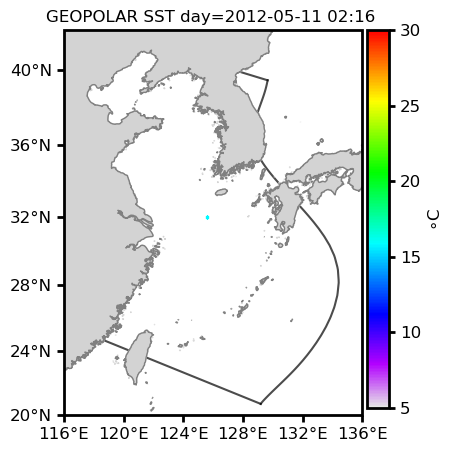

In [22]:
# %matplotlib
my_haxby_color = sio.loadmat('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/LYG_rainbow.mat')['rainbow']
my_haxby = LinearSegmentedColormap.from_list('lavergne',my_haxby_color, N = 256)
for timei in np.unique(obs_time):
# for timei in [15574.5,15821.5]:
    start_time = timei
    select_time = start_time + 0
    time_inrange = np.where(np.abs(obs_time -select_time) < 1e-10)

    lon_bdy = [116,136];
    lat_bdy = [20,42];

    plt.ion
    plt.rcParams['font.family'] = 'sans-serif'
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('2')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+4,4),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1],4),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)
    # ax.set_title('OISSTv2.1 day='+OBS_ds.obs_time.isel(datum=np.where(obs_time==select_time)[0][0]).data.astype('str')[:10],fontsize=20)
    # ax.set_title('Geo_Polar SST day='+(datetime.datetime(1970,1,1)+datetime.timedelta(select_time)).strftime('%Y-%m-%d %HH'),fontsize=20)
    ax.set_title('GEOPOLAR SST day='+(datetime.datetime(1970,1,1)+datetime.timedelta(select_time)).strftime('%Y-%m-%d %H:%M '),fontsize=12)

    cp = ax.scatter(obs_lon[time_inrange[0]],
                     obs_lat[time_inrange[0]],1,obs_value[time_inrange[0]],
                     vmin=5,vmax=30,
                     marker='s',cmap=my_haxby,
                     transform=ccrs.PlateCarree(),zorder=0)
    # ax.scatter(rlon2d,rlat2d,5,color='k',transform=ccrs.PlateCarree(),zorder=-1.9)
    # for i in range(0,rlon2d.shape[0],1):
    #     plt.plot(rlon2d[i,:],rlat2d[i,:],color = 'k',transform = ccrs.PlateCarree(),linewidth = 1,alpha = 0.7,zorder=-1)
    # for i in range(0,rlon2d.shape[1],1):
    #     plt.plot(rlon2d[:,i],rlat2d[:,i],color = 'k',transform = ccrs.PlateCarree(),linewidth = 1,alpha = 0.7,zorder=-1)
    for i in [0,-1]:
        plt.plot(rlon2d[i,:],rlat2d[i,:],color = 'k',transform = ccrs.PlateCarree(),linewidth = 1.5,alpha = 0.7,zorder=-2)
    for i in [0,-1]:
        plt.plot(rlon2d[:,i],rlat2d[:,i],color = 'k',transform = ccrs.PlateCarree(),linewidth = 1.5,alpha = 0.7,zorder=-2)
    position=fig.add_axes([0.82, 0.125,  0.045,0.755,])


    cb = fig.colorbar(cp, cax = position, orientation='vertical')
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('2')
    position.tick_params(direction = 'out', length =4, width = 2, labelsize = 12)
    # position.set_yticklabels(np.round(np.arange(0.2,1.4,0.2),1))
    cb.set_label('$\circ$C',fontsize = 12) 
    # plt.show()
    # plt.savefig('oisst_roms_ecs.pdf',bbox_inches='tight')
    plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/fig_obs/TEMP/obs_%s.jpeg'%((datetime.datetime(1970,1,1)+datetime.timedelta(select_time)).strftime('%Y%m%d%H')),bbox_inches='tight',dpi=400)
    # plt.savefig('./NOAA_GHRSST/geopolarsst_2017010612.jpeg',bbox_inches='tight',dpi=1200)
    # plt.savefig('./NOAA_OISST/oisst_2017010312.jpeg',bbox_inches='tight',dpi=1200)
    # plt.savefig('./MUR_SST/jplmur_sst_%s.jpeg'%((datetime.datetime(1970,1,1)+datetime.timedelta(select_time)).strftime('%Y%m%d%HH')),bbox_inches='tight',dpi=1200)
    plt.close()


In [ ]:

this_state = np.where((obs_type_org == 7) & (obs_depth_org >=0))
obs_time = obs_time_org[this_state]
obs_value = obs_value_org[this_state]
obs_lon = obs_lon_org[this_state]
obs_lat = obs_lat_org[this_state]
obs_depth = obs_depth_org[this_state]

In [ ]:
# %matplotlib
for timei in np.unique(obs_time):
# for timei in [15574.5,15821.5]:
    start_time = timei
    select_time = start_time + 0
    time_inrange = np.where(np.abs(obs_time -select_time) < 1e-10)

    lon_bdy = [116,136];
    lat_bdy = [20,42];

    plt.ion
    plt.rcParams['font.family'] = 'sans-serif'
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('2')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+4,4),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1],4),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)
    # ax.set_title('OISSTv2.1 day='+OBS_ds.obs_time.isel(datum=np.where(obs_time==select_time)[0][0]).data.astype('str')[:10],fontsize=20)
    # ax.set_title('Geo_Polar SST day='+(datetime.datetime(1970,1,1)+datetime.timedelta(select_time)).strftime('%Y-%m-%d %HH'),fontsize=20)
    ax.set_title('GEOPOLAR SST day='+(datetime.datetime(1970,1,1)+datetime.timedelta(select_time)).strftime('%Y-%m-%d %HH'),fontsize=12)

    cp = ax.scatter(obs_lon[time_inrange[0]],
                     obs_lat[time_inrange[0]],1,obs_value[time_inrange[0]],
                     vmin=5,vmax=30,
                     marker='s',cmap=my_haxby,
                     transform=ccrs.PlateCarree(),zorder=0)
    # ax.scatter(rlon2d,rlat2d,5,color='k',transform=ccrs.PlateCarree(),zorder=-1.9)
    # for i in range(0,rlon2d.shape[0],1):
    #     plt.plot(rlon2d[i,:],rlat2d[i,:],color = 'k',transform = ccrs.PlateCarree(),linewidth = 1,alpha = 0.7,zorder=-1)
    # for i in range(0,rlon2d.shape[1],1):
    #     plt.plot(rlon2d[:,i],rlat2d[:,i],color = 'k',transform = ccrs.PlateCarree(),linewidth = 1,alpha = 0.7,zorder=-1)
    for i in [0,-1]:
        plt.plot(rlon2d[i,:],rlat2d[i,:],color = 'k',transform = ccrs.PlateCarree(),linewidth = 1.5,alpha = 0.7,zorder=-2)
    for i in [0,-1]:
        plt.plot(rlon2d[:,i],rlat2d[:,i],color = 'k',transform = ccrs.PlateCarree(),linewidth = 1.5,alpha = 0.7,zorder=-2)
    position=fig.add_axes([0.82, 0.125,  0.045,0.755,])


    cb = fig.colorbar(cp, cax = position, orientation='vertical')
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('2')
    position.tick_params(direction = 'out', length =4, width = 2, labelsize = 12)
    # position.set_yticklabels(np.round(np.arange(0.2,1.4,0.2),1))
    cb.set_label('$\circ$C',fontsize = 12) 
    # plt.show()
    # plt.savefig('oisst_roms_ecs.pdf',bbox_inches='tight')
    plt.savefig('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/fig_obs/SALT/obs_%s.jpeg'%((datetime.datetime(1970,1,1)+datetime.timedelta(select_time)).strftime('%Y%m%d%H')),bbox_inches='tight',dpi=400)
    # plt.savefig('./NOAA_GHRSST/geopolarsst_2017010612.jpeg',bbox_inches='tight',dpi=1200)
    # plt.savefig('./NOAA_OISST/oisst_2017010312.jpeg',bbox_inches='tight',dpi=1200)
    # plt.savefig('./MUR_SST/jplmur_sst_%s.jpeg'%((datetime.datetime(1970,1,1)+datetime.timedelta(select_time)).strftime('%Y%m%d%HH')),bbox_inches='tight',dpi=1200)
    plt.close()
